## Imports

In [1]:
import numpy as np
import scipy as scp
import pandas as pd
import time
from matplotlib import pyplot as plt

## Prepare raw_data.csv-File
used so for testing the data doesn't need to be fetched from grafana.

In [2]:
data_df = pd.read_csv("data/2024-03-10_testset_filtered.csv")
data_df["ticks"] = data_df["ticks"] / 1000 + time.time()
data_df["time"] = pd.to_datetime(data_df['ticks'],unit='s')
del data_df["ticks"]
# set index. important!
data_df = data_df.set_index("time")

#### add the "magnitude" columns combining x/y/z

In [3]:
data_df["xyzH"] = np.sqrt(data_df["xH"] ** 2 + data_df["yH"] ** 2 + data_df["zH"] ** 2)
data_df["xyzL"] = np.sqrt(data_df["xL"] ** 2 + data_df["yL"] ** 2 + data_df["zL"] ** 2)

#### compensate the data-aquisition-jitter (by upsampling and interpolation)

Alternative: Use nearest-neighbour or spline-interpolation instead of linear one?

In [4]:
# method=linear = ignores the index and treats them as equally spaced. not suitable for usecase, use method=time!
data_df = data_df.resample("0.001s").mean().interpolate(method='time')

## remove noise and split into "body" and "gravitation"-branches

In [5]:
# define butterworth filter
def bworth_filter(data, f_sample, order, f_corner, btype="low"):
    cutoff = f_corner / (0.5 * f_sample)
    b, a = scp.signal.butter(order, cutoff, btype=btype, analog=False)

    return scp.signal.filtfilt(b, a, data)

# apply filter to all columns
body_df = data_df.apply(lambda col: bworth_filter(col, 1000, 3, 20))

gravity_df = data_df.apply(lambda col: bworth_filter(col, 1000, 3, 0.3))

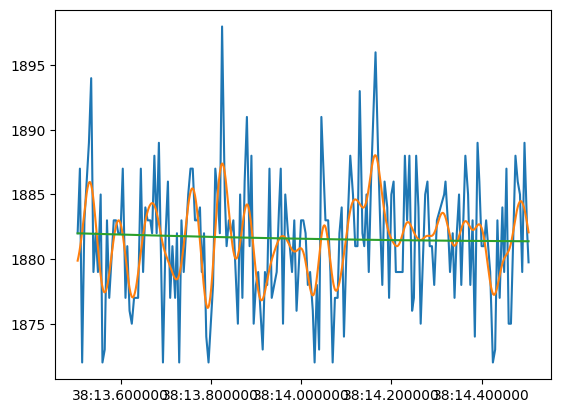

In [6]:
plt.plot(data_df.index[100:1100], data_df["xH"][100:1100])
plt.plot(body_df.index[100:1100], body_df["xH"][100:1100])
plt.plot(gravity_df.index[100:1100], gravity_df["xH"][100:1100])

In [7]:
#baseline_df = pd.merge_asof(body_df, gravity_df, left_index=True, right_index=True, direction="nearest", suffixes=("_body", "_gravity"))
baseline_df = pd.merge(body_df, gravity_df, left_index=True, right_index=True, how="outer", suffixes=("_body", "_gravity"))

In [8]:
# derivate "acceleration to jerk" 
derivative_df = baseline_df.apply(lambda col: np.gradient(col, edge_order=2))

In [9]:
intermediate_df = pd.merge(baseline_df, derivative_df, left_index=True, right_index=True, how="outer", suffixes=("_accel", "_jerk"))

## Sampling/Batching for statistical feature generation

In [10]:
## sample by time duration
TIME_DURATION = "0.5s"
#data_df['window_label'] = data_df['time'].apply(lambda ts: ts.floor("0.5s"))

intermediate_df["time_tmp"] = intermediate_df.index
intermediate_df['window_label'] = intermediate_df["time_tmp"].apply(lambda ts: ts.floor(TIME_DURATION))


In [11]:
## sample by count
BATCH_SIZE = 50
intermediate_df['window_label'] = np.arange(len(intermediate_df)) // BATCH_SIZE

### process the groups one after another

In [46]:
#intermediate_df.loc[intermediate_df["window_label"] == 1].describe()

In [12]:
output_data = []

grouped_df = intermediate_df.groupby('window_label')

for window_label, group in grouped_df:
    del group["time_tmp"]
    del group["window_label"]
    timestamps = list(group.index.map(lambda _: _.timestamp()))
    
    v_mean = group.mean().add_suffix("_Tmean")
    v_std = group.std().add_suffix("_Tstd")
    v_mad = group.apply(lambda col: scp.stats.median_abs_deviation(col.values)).add_suffix("_Tmad")
    v_min = group.min().add_suffix("_Tmin")
    v_max = group.max().add_suffix("_Tmax")
    v_sma = group.apply(lambda col: scp.integrate.simpson(y=np.abs(col.values), x=timestamps)).add_suffix("_Tsma")
    v_iqr = group.apply(lambda col: np.subtract(*np.percentile(col.values, [75, 25]))).add_suffix("_Tiqr")
    v_entropy = group.apply(lambda col: scp.stats.entropy(col.values)).add_suffix("_Tentropy")
    v_energy = group.apply(lambda col: np.average(np.power(col.values, 2))).add_suffix("_Tenergy")
    
    combi = pd.concat([v_mean, v_std, v_mad, v_min, v_max, v_sma, v_iqr, v_entropy, v_energy], axis=0)
    
    
    output_data.append(combi)

In [13]:
pd.DataFrame(output_data)

,xH_body_accel_Tmean,yH_body_accel_Tmean,zH_body_accel_Tmean,xL_body_accel_Tmean,yL_body_accel_Tmean,zL_body_accel_Tmean,magni_body_accel_Tmean,temp_body_accel_Tmean,xyzH_body_accel_Tmean,xyzL_body_accel_Tmean,...,xH_gravity_jerk_Tenergy,yH_gravity_jerk_Tenergy,zH_gravity_jerk_Tenergy,xL_gravity_jerk_Tenergy,yL_gravity_jerk_Tenergy,zL_gravity_jerk_Tenergy,magni_gravity_jerk_Tenergy,temp_gravity_jerk_Tenergy,xyzH_gravity_jerk_Tenergy,xyzL_gravity_jerk_Tenergy
0,1879.648491,1883.626395,1883.621992,-494.990203,519.020945,10113.808603,442.324099,373.586845,3260.244776,10139.725904,...,1.148610e-06,8.936912e-08,6.431776e-06,2.768864e-03,7.695761e-03,4.934461e-05,1.063096e-08,1.340172e-04,1.054052e-06,9.205201e-05
1,1877.923604,1886.104255,1886.657954,-416.625588,602.429804,10142.103833,441.437812,377.274489,3262.439861,10169.036707,...,1.101603e-06,8.923169e-08,6.539788e-06,2.709812e-03,7.635458e-03,4.043328e-05,4.658305e-09,1.406175e-04,1.105564e-06,7.983315e-05
2,1883.133250,1885.274256,1881.047473,-497.195530,537.816258,10042.486830,439.437802,295.232978,3261.723665,10069.752540,...,1.046047e-06,8.853856e-08,6.607433e-06,2.627939e-03,7.505290e-03,3.192472e-05,4.621892e-08,1.460275e-04,1.152880e-06,6.757285e-05
3,1880.224744,1884.527239,1881.426526,-466.071847,587.564538,10034.850585,441.092899,294.949038,3259.832404,10064.019447,...,9.834846e-07,8.735620e-08,6.635400e-06,2.525622e-03,7.308450e-03,2.408002e-05,1.448999e-07,1.500876e-04,1.195612e-06,5.562666e-05
4,1879.329347,1883.168401,1883.611752,-449.599960,595.414090,10052.757063,440.009968,301.235509,3259.790465,10081.004329,...,9.155447e-07,8.575804e-08,6.624939e-06,2.405698e-03,7.049870e-03,1.711777e-05,3.098361e-07,1.526932e-04,1.233416e-06,4.431431e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,1883.455156,1883.543599,1880.328086,-504.506936,594.144033,10033.505701,457.299435,305.386061,3260.490910,10064.607448,...,8.017255e-12,3.382373e-11,1.395031e-10,2.455776e-10,3.186730e-11,6.098515e-11,3.632245e-14,1.336337e-10,1.398381e-10,7.028666e-11
294,1883.441515,1881.957449,1879.869340,-480.110996,550.597210,10000.760090,458.124584,305.207808,3259.307519,10028.886304,...,1.949879e-12,8.489979e-12,3.279528e-11,4.695399e-11,6.445970e-12,2.284234e-11,3.877134e-15,2.954528e-11,3.365517e-11,2.597143e-11
295,1880.135423,1882.941510,1882.656104,-489.854447,555.590923,10041.509275,458.498089,304.381162,3259.574856,10069.542645,...,2.929186e-13,1.283723e-12,4.662465e-12,5.427970e-12,7.751404e-13,4.474517e-12,3.211578e-16,3.975007e-12,4.910327e-12,5.044111e-12
296,1878.214676,1884.002037,1881.696652,-474.448924,569.854622,10004.390314,459.352761,313.442764,3258.527417,10032.538791,...,1.722761e-14,7.405122e-14,2.542944e-13,2.392655e-13,3.421198e-14,3.005829e-13,1.665929e-17,2.066347e-13,2.754343e-13,3.364413e-13


In [56]:
combi

xH_body_accel_mean        1.878835e+03
yH_body_accel_mean        1.881864e+03
zH_body_accel_mean        1.881968e+03
xL_body_accel_mean       -5.214225e+02
yL_body_accel_mean        5.386793e+02
                              ...     
xL_gravity_jerk_mad       1.574935e-08
yL_gravity_jerk_mad       5.650861e-09
zL_gravity_jerk_mad       2.204160e-08
magni_gravity_jerk_mad    1.846843e-10
temp_gravity_jerk_mad     1.666137e-08
Length: 160, dtype: float64